[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

## Arquitecturas

La primera idea que podemos probar es utilizar una `CNN` que no reduzca las dimensiones de los diferentes mapas de características, utilizando la correcta configuración de filtros y sin usar `pooling`. 

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)

Este tipo de arquitectura, sin embargo, no será capaz de extraer características a diferentes escalas y además será computacionalmente muy costos. Podemos aliviar estos problemas utilizando una arquitectura `encoder-decoder`, en la que en una primera etapa una `CNN` extrae características a diferentes escalas y luego otra `CNN` recupera las dimensiones originales.

![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)

Para poder utilizar este tipo de arquitecturas necesitamos alguna forma de incrementar la dimensión de un mapa de características. De entre las diferentes opciones, una muy utilizada es el uso de `convoluciones traspuestas`, una capa muy parecida a la capa convolucional que "aprende" la mejor forma de aumentar un mapa de características aplicando filtros que aumentan la resolución.

![](https://miro.medium.com/max/1972/1*kOThnLR8Fge_AJcHrkR3dg.gif)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import torch

input = torch.randn(64, 10, 20, 20)
# aumentamos la dimensión x2
conv_trans = torch.nn.ConvTranspose2d(
    in_channels=10, 
    out_channels=10, 
    kernel_size=2, 
    stride=2)
output = conv_trans(input)
output.shape

torch.Size([64, 10, 40, 40])

Puedes aprender más sobre esta operación en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) de `Pytorch`. De esta manera podemos diseñar arquitecturas más eficientes capaces de extraer información relevante a varias escalas. Sin embargo, puede ser un poco complicado recuperar información en el `decoder` simplemente a partir de la salida del `encoder`. Para resolver este problema se desarrolló una de las arquitecturas más conocidas y utilizadas para la segmentación: la red `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

Esta arquitectura es muy similar a la anterior, con la diferencia de que en cada etapa del `decoder` no solo entra la salida de la capa anterior sino también la salida de la capa correspondiente del `encoder`. De esta manera la red es capaz de aprovechar mucho mejor la información a las diferentes escalas.

Vamos a ver cómo implementar esta arquitectura para hacer segmentación de MRIs.

## El Dataset

Podemos descargar un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación usando el siguiente enlace.

Nuestro objetivo será el de segmentar una MRI cerebral para detectar la materia gris y blanca. Determinar la cantidad de ambas así como su evolución en el tiempo para un mismo paciente es clave para la detección temprana y tratamiento de enfermedades como el alzheimer. 

In [5]:
import os 
from pathlib import Path

path = Path('/content/drive/MyDrive/plastoformo')
imgs = [path/'train_mask'/i for i in os.listdir(path/'train_mask') if i.endswith('.jpg')]
ixs = [i.split('_')[-1] for i in os.listdir(path/'train_mask')]
masks = [path/'train_mask'/(Path(img).stem + '_mask.png') for img in imgs]

len(imgs), len(masks)

(1000, 1000)

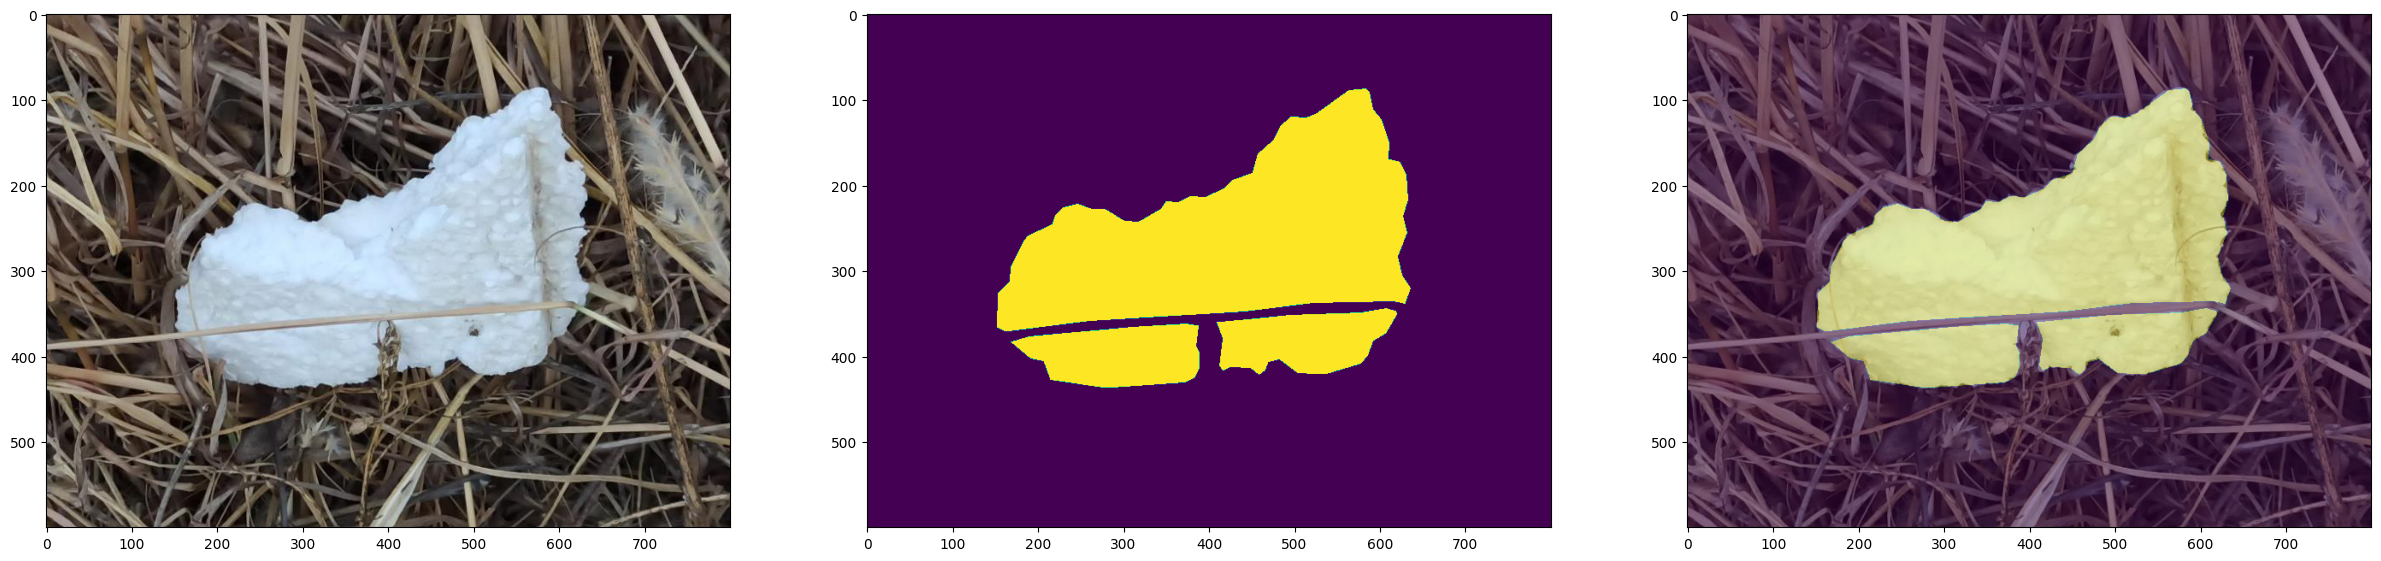

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
img = Image.open(imgs[1])



mask = np.array(Image.open(masks[1]))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como `arrays` de `NumPy` (que podemos cargar con la función `np.load`). Ya están normalizadas y en formato `float32`.

In [31]:
width, height = img.size
img_array = np.array(img)
dtype = img_array.dtype
max_value = img_array.max()
min_value = img_array.min()

print("Dimensiones de la imagen: ", width, "x", height)
print("Tipo de datos: ", dtype)
print("Valor máximo: ", max_value)
print("Valor mínimo: ", min_value)


Dimensiones de la imagen:  800 x 600
Tipo de datos:  uint8
Valor máximo:  255
Valor mínimo:  0


En cuanto a las máscaras, también las tenemos guardadas como `arrays` de `NumPy`. En este caso el tipo es `unit8`, y la resolución es la misma que las de la imagen original. En cada píxel podemos encontrar tres posibles valores: 0, 1 ó 2. Este valor indica la clase (0 corresponde con materia blanca, 1 con materia gris, 2 con *background*).

In [32]:
mask_array = np.array(mask)
mask_dtype = mask_array.dtype
mask_max_value = mask_array.max()
mask_min_value = mask_array.min()

print("Dimensiones de la máscara: ", mask_array.shape)
print("Tipo de datos de la máscara: ", mask_dtype)
print("Valor máximo de la máscara: ", mask_max_value)
print("Valor mínimo de la máscara: ", mask_min_value)


Dimensiones de la máscara:  (600, 800)
Tipo de datos de la máscara:  uint8
Valor máximo de la máscara:  1
Valor mínimo de la máscara:  0


A la hora de entrenar nuestra red necesitaremos esta máscara en formato `one-hot encoding`, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [33]:
# one-hot encoding
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32) 

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((600, 800, 3), dtype('float32'), 1.0, 0.0)

## SqueezeNet


SqueezeNet es una arquitectura de red neuronal convolucional (CNN) diseñada para comprimir modelos de redes neuronales profundos y reducir su tamaño sin sacrificar significativamente el rendimiento. Fue desarrollada por investigadores en DeepScale (una startup de inteligencia artificial) en 2016.

La principal idea detrás de SqueezeNet es reducir el número de parámetros en una red neuronal convolucional sin afectar demasiado su capacidad de aprendizaje. Logra esto utilizando una combinación de varias técnicas de compresión, como la reducción de filtros, la fusión de capas y el uso de filtros 1x1.

La arquitectura SqueezeNet reemplaza los bloques convolucionales tradicionales de 3x3 por bloques "squeeze" de 1x1, seguidos de bloques "expand" que combinan la información de salida de los bloques squeeze en un espacio dimensional más grande. Esto permite reducir significativamente el número de parámetros en comparación con otras arquitecturas CNN, al tiempo que se mantiene la capacidad de aprendizaje.

Al reducir el número de parámetros, SqueezeNet es especialmente útil en entornos con recursos limitados, como dispositivos móviles o sistemas embebidos, donde el tamaño y la eficiencia computacional son factores críticos. También puede ser útil en aplicaciones de aprendizaje automático en la nube, donde la reducción del tamaño del modelo puede ayudar a mejorar la velocidad de inferencia y reducir los costos de almacenamiento.

![](https://miro.medium.com/v2/resize:fit:1122/1*dVaL1bcv5Ewpz-wen7IXCA.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

def conv3x3_bn(ci, co):
    return nn.Sequential(
        nn.Conv2d(ci, co, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(co),
        nn.ReLU(inplace=True)
    )

def deconv(ci, co):
    return nn.Sequential(
        nn.ConvTranspose2d(ci, co, kernel_size=2, stride=2),
        nn.BatchNorm2d(co),
        nn.ReLU(inplace=True)
    )

class out_conv(nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = nn.ConvTranspose2d(ci, co, kernel_size=2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = nn.Conv2d(co, coo, kernel_size=1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (0,diffY, 0, diffX))
        x = self.conv(x1)
        x = self.final(x)
        return x

class SqueezeNet(nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.squeezenet1_1(pretrained=True)
        if in_ch != 3:
            self.encoder.features[0] = nn.Conv2d(in_ch, 64, kernel_size=3, stride=2)

        self.deconv1 = deconv(512, 256)
        self.deconv2 = deconv(256, 128)
        self.deconv3 = deconv(128, 64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone()
        x = self.encoder.features(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.out(x, x_in)
        return x


In [2]:
model = SqueezeNet()
output = model(torch.randn((10,3,800,600)))
output.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([10, 3, 800, 600])

## Fit de 1 muestra

Para comprobar que todo funciona vamos a hacer el fit de una sola muestra. Para optimizar la red usamos la función de pérdida `BCEWithLogitsLoss`, que aplicará la función de activación `sigmoid` a las salidas de la red (para que estén entre 0 y 1) y luego calcula la función `binary cross entropy`.

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y.float())
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [8]:
img_array = np.array(img)
mask_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0)
img_tensor = torch.tensor(img_array.transpose(2, 0, 1), dtype=torch.float32).unsqueeze(0)
mask_tensor = mask_tensor.repeat(1, 3, 1, 1)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 600, 800]), torch.Size([1, 3, 600, 800]))

In [9]:
img_tensor = img_tensor.float()

fit(model, img_tensor, mask_tensor, epochs=50)

<ipython-input-5-793ab3ccbd01>:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


Epoch 1/50 loss 0.72249
Epoch 2/50 loss 0.68132
Epoch 3/50 loss 0.65816
Epoch 4/50 loss 0.63987
Epoch 5/50 loss 0.62394
Epoch 6/50 loss 0.61109
Epoch 7/50 loss 0.60001
Epoch 8/50 loss 0.58992
Epoch 9/50 loss 0.58105
Epoch 10/50 loss 0.57298
Epoch 11/50 loss 0.56570
Epoch 12/50 loss 0.55935
Epoch 13/50 loss 0.55394
Epoch 14/50 loss 0.54932
Epoch 15/50 loss 0.54530
Epoch 16/50 loss 0.54184
Epoch 17/50 loss 0.53882
Epoch 18/50 loss 0.53609
Epoch 19/50 loss 0.53363
Epoch 20/50 loss 0.53140
Epoch 21/50 loss 0.52937
Epoch 22/50 loss 0.52751
Epoch 23/50 loss 0.52574
Epoch 24/50 loss 0.52411
Epoch 25/50 loss 0.52257
Epoch 26/50 loss 0.52109
Epoch 27/50 loss 0.51967
Epoch 28/50 loss 0.51829
Epoch 29/50 loss 0.51695
Epoch 30/50 loss 0.51566
Epoch 31/50 loss 0.51439
Epoch 32/50 loss 0.51314
Epoch 33/50 loss 0.51193
Epoch 34/50 loss 0.51075
Epoch 35/50 loss 0.50958
Epoch 36/50 loss 0.50844
Epoch 37/50 loss 0.50731
Epoch 38/50 loss 0.50619
Epoch 39/50 loss 0.50508
Epoch 40/50 loss 0.50399
Epoch 41/

La función de pérdida va bajando, por lo que parece que está funcionando bien. Sin embargo, necesitamos alguna métrica para evaluar cuánto se parecen las máscaras predichas a las reales. Para ello podemos usar la métrica `IoU`, de la que ya hablamos anteriormente, y que calcula la relación entre la intersección y la unión de dos áreas.

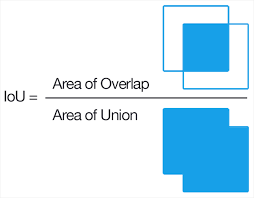

In [9]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [10]:
def fit(model, X, y, epochs=100, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y.float())
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [11]:
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.75752 iou 0.14790
Epoch 2/100 loss 0.74071 iou 0.14176
Epoch 3/100 loss 0.70610 iou 0.13043
Epoch 4/100 loss 0.69228 iou 0.15085
Epoch 5/100 loss 0.67336 iou 0.18399
Epoch 6/100 loss 0.64443 iou 0.24990
Epoch 7/100 loss 0.60026 iou 0.39325
Epoch 8/100 loss 0.53382 iou 0.65592
Epoch 9/100 loss 0.48806 iou 0.77360
Epoch 10/100 loss 0.46713 iou 0.85979
Epoch 11/100 loss 0.44963 iou 0.86882
Epoch 12/100 loss 0.43497 iou 0.86715
Epoch 13/100 loss 0.42227 iou 0.87619
Epoch 14/100 loss 0.41038 iou 0.88816
Epoch 15/100 loss 0.40016 iou 0.88887
Epoch 16/100 loss 0.39056 iou 0.88714
Epoch 17/100 loss 0.38003 iou 0.89482
Epoch 18/100 loss 0.37050 iou 0.89882
Epoch 19/100 loss 0.36204 iou 0.89612
Epoch 20/100 loss 0.35310 iou 0.90632
Epoch 21/100 loss 0.34457 iou 0.91085
Epoch 22/100 loss 0.33613 iou 0.90942
Epoch 23/100 loss 0.32797 iou 0.91752
Epoch 24/100 loss 0.32018 iou 0.90746
Epoch 25/100 loss 0.31181 iou 0.92588
Epoch 26/100 loss 0.30442 iou 0.91466
Epoch 27/100 loss 0.2

Ahora podemos generar predicciones para obtener máscaras de segmentación

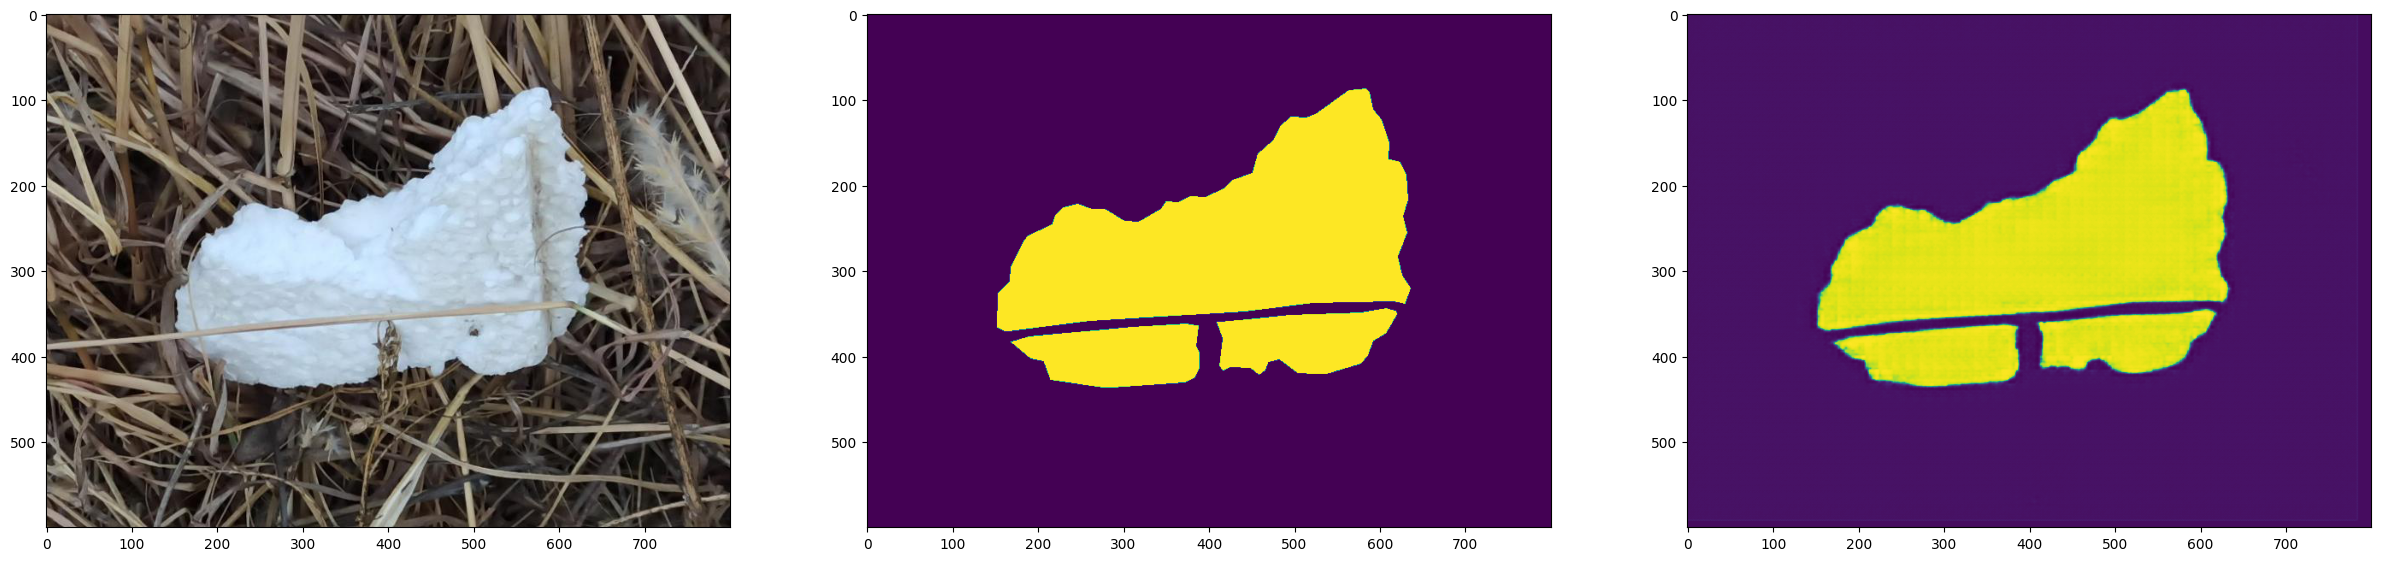

In [12]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.sigmoid(output)

# Obtener la máscara predicha en escala de grises
pred_mask_gray = torch.mean(pred_mask, dim=0)

# Mostrar las imágenes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(pred_mask_gray.cpu().numpy())
plt.show()

## Entrenando con todo el dataset

Una vez hemos validado que nuestra red es capaz de hacer el fit de una imágen, podemos entrenar la red con todo el dataset.

In [2]:
from torchvision import transforms

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=3):
    self.X = X
    self.y = y
    self.n_classes = n_classes
    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((800, 600))
    ])

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    img = Image.open(self.X[ix])
    mask = Image.open(self.y[ix])

    img = self.transform(img)
    mask = self.transform(mask)

    mask = torch.nn.functional.one_hot(mask.squeeze().long(), num_classes=self.n_classes).permute(2, 0, 1).float()

    return img, mask


In [8]:
dataset = {
    'train': Dataset(imgs[:-100], masks[:-100]),
    'test': Dataset(imgs[-100:], masks[-100:])
}

len(dataset['train']), len(dataset['test'])

(900, 100)

In [9]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=32, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([16, 3, 800, 600]), torch.Size([16, 3, 800, 600]))

In [10]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [41]:
model = UNet()
hist = fit(model, dataloader, epochs=3)

loss 0.57253 iou 0.42512:  91%|█████████ | 52/57 [02:11<00:12,  2.53s/it]


KeyboardInterrupt: ignored

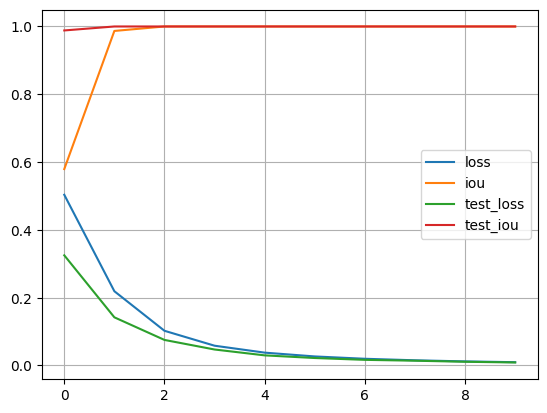

In [16]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Transfer Learning

Podemos mejorar nuestros resultados si en vez de entrenar nuestra `UNet` desde cero utilizamos una red ya entrenada gracias al `transfer learning`. Para ello usaremos `ResNet` como `backbone` en el `encoder` de la siguiente manera.

In [5]:
import torchvision

In [6]:
encoder = torchvision.models.resnet18(pretrained=True)
encoder

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

def conv3x3_bn(ci, co):
    return nn.Sequential(
        nn.Conv2d(ci, co, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(co),
        nn.ReLU(inplace=True)
    )

def deconv(ci, co):
    return nn.Sequential(
        nn.ConvTranspose2d(ci, co, kernel_size=2, stride=2),
        nn.BatchNorm2d(co),
        nn.ReLU(inplace=True)
    )

class out_conv(nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = nn.ConvTranspose2d(ci, co, kernel_size=2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = nn.Conv2d(co, coo, kernel_size=1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (0,diffY, 0, diffX))
        x = self.conv(x1)
        x = self.final(x)
        return x

class SqueezeNet(nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.squeezenet1_1(pretrained=True)
        if in_ch != 3:
            self.encoder.features[0] = nn.Conv2d(in_ch, 64, kernel_size=3, stride=2)

        self.deconv1 = deconv(512, 256)
        self.deconv2 = deconv(256, 128)
        self.deconv3 = deconv(128, 64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone()
        x = self.encoder.features(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = self.out(x, x_in)
        return x


In [11]:
model = SqueezeNet()
output = model(torch.randn((10,3,800,600)))
output.shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 53.4MB/s]


torch.Size([10, 3, 800, 600])

In [12]:
model =SqueezeNet()
hist = fit(model, dataloader, epochs=3)

  0%|          | 0/57 [00:09<?, ?it/s]


OutOfMemoryError: ignored

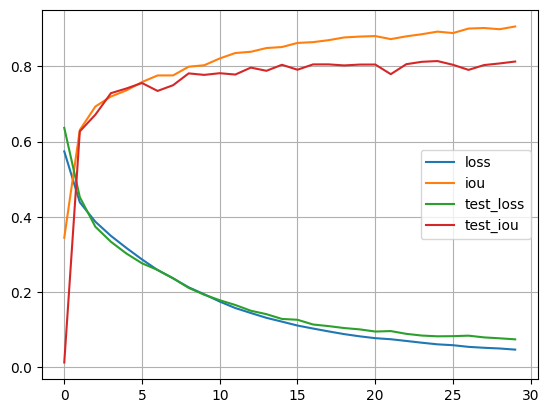

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

En este caso observamos como la red converge más rápido, sin embargo no obtenemos una gran mejora de prestaciones ya que nuestro dataset es muy pequeño y la naturaleza de las imágenes es muy distinta a las utilizadas para entrenar `ResNet`. Podemos generar máscaras para imágenes del dataset de test de la siguiente manera.

<ipython-input-27-79df0860ce6f>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


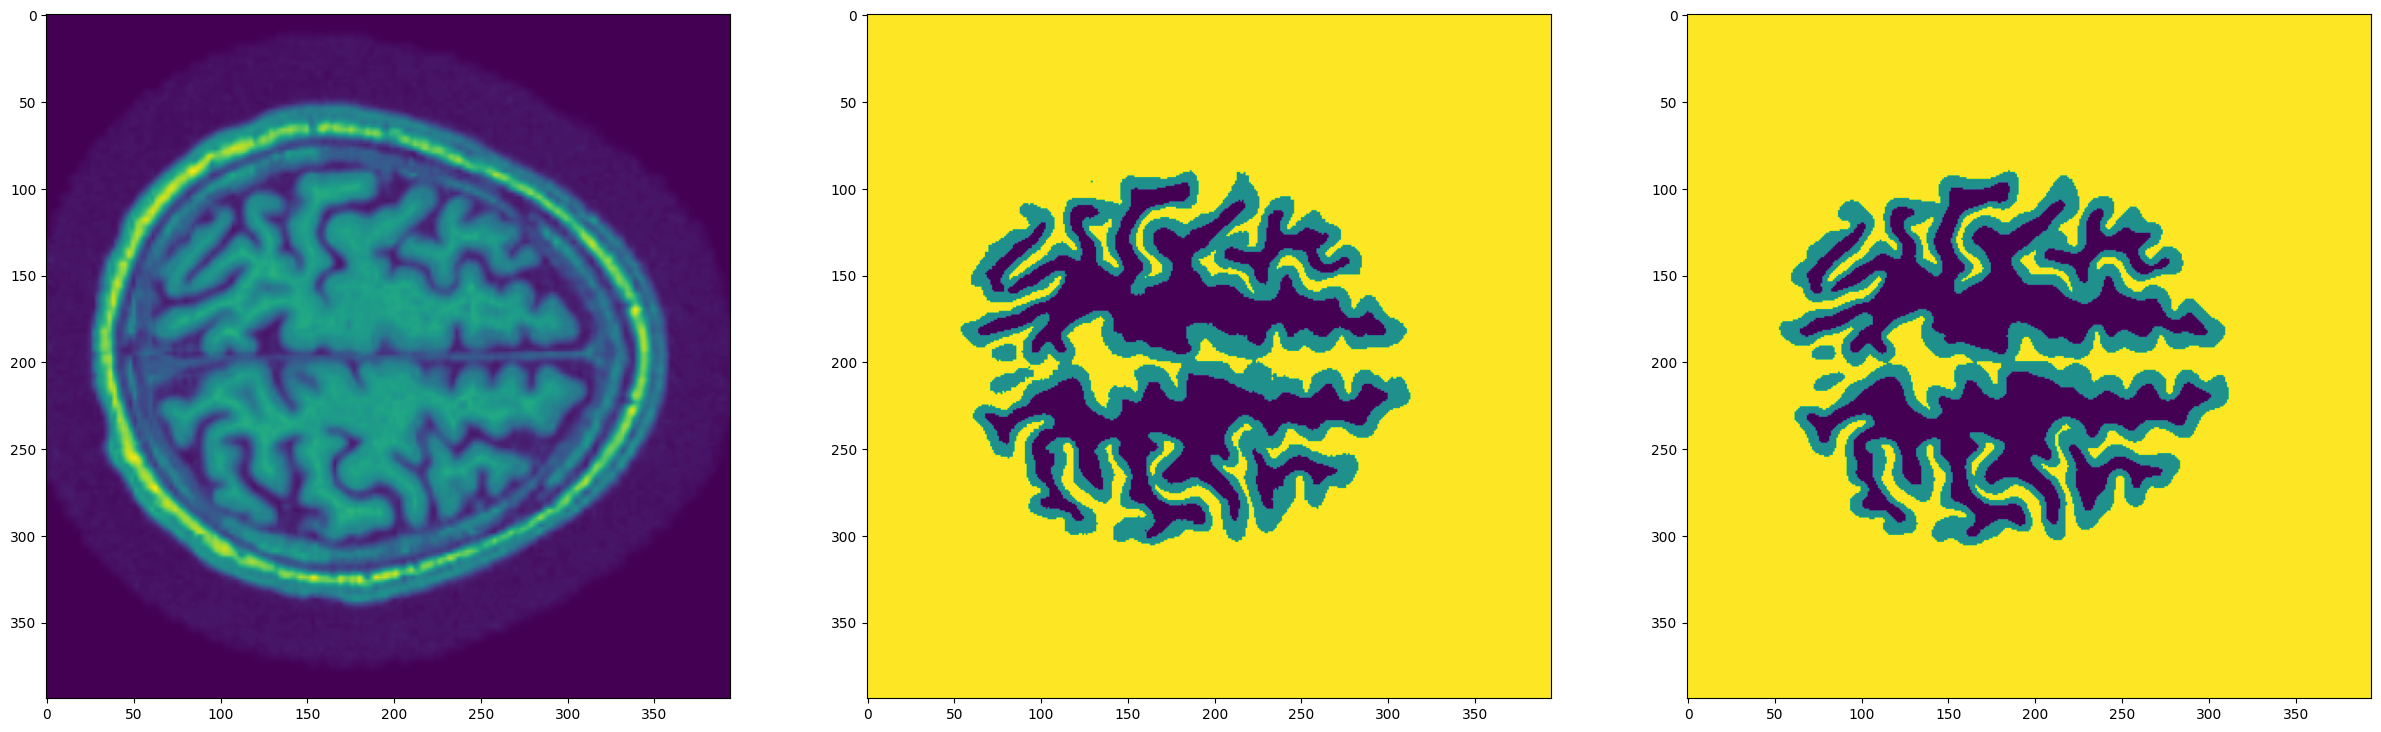

In [ ]:
import random

model.eval()
with torch.no_grad():
    ix = random.randint(0, len(dataset['test'])-1)
    img, mask = dataset['test'][ix]
    output = model(img.unsqueeze(0).to(device))[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze(0))
ax2.imshow(torch.argmax(mask, axis=0))
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

## Resumen

En este post hemos visto como podemos implementar y entrenar una red convolucional para llevar a cabo la tarea de segmentación semántica. Esta tarea consiste en clasificar todos y cada uno de los píxeles en una imagen. De esta manera podemos producir máscaras de segmentación que nos permiten localizar los diferentes objetos presentes en una imagen de forma mucho más precisa que la que podemos conseguir con la detección de objetos. Este tipo de tarea puede utilizarse en aplicaciones como la conducción autónoma o sistemas de diagnóstico médico, como hemos visto en el ejemplo de este post.